In [12]:
"""
Large-Scale Self-Organizing Map (SOM) Time Series Anomaly Detection

This module provides an efficient implementation of SOM-based anomaly detection
for large-scale time series data, specifically designed for IMU sensor data.
"""
import gc
from typing import Self

import matplotlib.pyplot as plt
import seaborn as sns
from minisom import MiniSom
from numpy import (
    arange,
    array,
    bool_,
    corrcoef,
    float32,
    floating,
    hstack,
    integer,
    isin,
    linalg,
    linspace,
    mean,
    percentile,
    random,
    std,
    unique,
    var,
    where,
    zeros,
)
from numpy.typing import NDArray
from pandas import read_csv
from scipy.stats import ks_2samp
from sklearn.preprocessing import RobustScaler, StandardScaler

# Type aliases for better readability
FloatArray = NDArray[floating]
BoolArray = NDArray[bool_]
IntArray = NDArray[integer]
SOMCoordinate = tuple[int, int]

In [ ]:
try:
    X_train = read_csv("../data/PAMAP2/x_train_data.csv")
    X_test = read_csv("../data/PAMAP2/x_test_data.csv")
    y_train = read_csv("../data/PAMAP2/y_train_data.csv")
    y_test = read_csv("../data/PAMAP2/y_test_data.csv")
except FileNotFoundError as e:
    print(
        f"Error loading data files: {e}"
        "Please ensure the PAMAP2 data files are in the correct location."
    )
    raise e

all_imu_columns = (
    [f"IMU_hand_{i}" for i in range(1, 15)]
    + [f"IMU_chest_{i}" for i in range(1, 15)]
    + [f"IMU_ankle_{i}" for i in range(1, 15)]
)
train_imu_data = X_train[all_imu_columns].values.astype(float32)
test_imu_data = X_test[all_imu_columns].values.astype(float32)
# Extract activity labels (assuming single column, adjust if needed)
train_labels = (
    y_train.values.flatten() if y_train.shape[1] == 1 else y_train.iloc[:, 0].values
)
test_labels = (
    y_test.values.flatten() if y_test.shape[1] == 1 else y_test.iloc[:, 0].values
)
print(f"Data shape - Train: {train_imu_data.shape}, Test: {test_imu_data.shape}")
print(f"Feature count: {len(all_imu_columns)} IMU sensors")
print(f"Unique activities in training: {unique(train_labels)}")
print(f"Unique activities in test: {unique(test_labels)}")

Data shape - Train: (140360, 42), Test: (35138, 42)
Feature count: 42 IMU sensors
Unique activities in training: [ 1  2  3  4  5  6  7 12 13 16 17 24]
Unique activities in test: [ 1  2  3  4  5  6  7 12 13 16 17 24]


In [ ]:
def get_activity_name(activity_id: int) -> str:
    """
    Convert PAMAP2 activity ID to readable name.

    Args:
        activity_id: Numeric activity identifier

    Returns:
        Human-readable activity name
    """
    return {
        1: "lying",
        2: "sitting",
        3: "standing",
        4: "walking",
        5: "running",
        6: "cycling",
        7: "Nordic_walking",
        9: "watching_TV",
        10: "computer_work",
        11: "car_driving",
        12: "ascending_stairs",
        13: "descending_stairs",
        16: "vacuum_cleaning",
        17: "ironing",
        18: "folding_laundry",
        19: "house_cleaning",
        20: "playing_soccer",
        24: "rope_jumping",
    }.get(activity_id, f"activity_{activity_id}")

In [ ]:
class SOMTimeSeriesAnomalyDetector:
    """
    Large-scale Self-Organizing Map (SOM) based anomaly detector for time series data.

    This class implements an efficient SOM-based anomaly detection system specifically
    designed for high-dimensional time series data such as IMU sensor readings. It uses
    sliding windows to capture temporal patterns and employs memory-efficient batch
    processing to handle large datasets.

    Attributes:
        som_size: Tuple defining the SOM grid dimensions (rows, columns)
        sigma: Initial radius of the neighborhood function
        learning_rate: Initial learning rate for SOM training
        window_size: Size of sliding windows for temporal pattern extraction
        stride: Step size between consecutive windows
        threshold_percentile: Percentile for anomaly threshold calculation
        batch_size: Number of samples processed in each batch
        use_robust_scaling: Whether to use RobustScaler instead of StandardScaler
        scaler: Fitted data scaler instance
        som: Trained SOM instance
        threshold: Calculated anomaly detection threshold
        feature_names: Names of input features
    """

    def __init__(
        self,
        som_size: tuple[int, int] = (20, 20),
        sigma: float = 1.0,
        learning_rate: float = 0.5,
        window_size: int = 10,
        stride: int = 1,
        threshold_percentile: float = 95.0,
        batch_size: int = 1000,
        use_robust_scaling: bool = True,
    ) -> None:
        """
        Initialize the SOM-based anomaly detector.

        Args:
            som_size: Tuple of (height, width) defining SOM grid dimensions
            sigma: Initial radius of the neighborhood function in SOM training
            learning_rate: Initial learning rate for SOM weight updates
            window_size: Number of consecutive time points in each sliding window
            stride: Number of time points to advance between consecutive windows
            threshold_percentile: Percentile of training error distribution used as anomaly threshold
            batch_size: Number of samples to process simultaneously for memory efficiency
            use_robust_scaling: If True, use RobustScaler; otherwise use StandardScaler

        Example:
            >>> detector = SOMTimeSeriesAnomalyDetector(
            ...     som_size=(15, 15),
            ...     window_size=20,
            ...     stride=5,
            ...     threshold_percentile=95.0
            ... )
        """
        self.som_size = som_size
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.window_size = window_size
        self.stride = stride
        self.threshold_percentile = threshold_percentile
        self.batch_size = batch_size
        self.use_robust_scaling = use_robust_scaling

        # Use RobustScaler for IMU data (handles outliers better)
        self.scaler: RobustScaler | StandardScaler = (
            RobustScaler() if use_robust_scaling else StandardScaler()
        )
        self.som: MiniSom | None = None
        self.threshold: float | None = None
        self.feature_names: list[str] | None = None

    def create_sliding_windows_efficient(
        self, data: FloatArray, stride: int | None = None
    ) -> FloatArray:
        """
        Create sliding windows from time series data with memory efficiency.

        This method transforms the input time series into overlapping windows,
        where each window captures temporal patterns. The windows are flattened
        to create feature vectors for SOM training.

        Args:
            data: Input time series data of shape (n_samples, n_features)
            stride: Step size between windows. If None, uses self.stride

        Returns:
            Array of shape (n_windows, window_size * n_features) containing
            flattened sliding windows

        Raises:
            ValueError: If data has insufficient samples for window creation

        Example:
            >>> data = np.random.randn(1000, 5)
            >>> windows = detector.create_sliding_windows_efficient(data)
            >>> print(windows.shape)  # (991, 50) for window_size=10
        """
        if stride is None:
            stride = self.stride

        n_samples, n_features = data.shape

        if n_samples < self.window_size:
            raise ValueError(
                f"Data has {n_samples} samples but window size is {self.window_size}"
            )
        n_windows = (n_samples - self.window_size) // stride + 1
        # Pre-allocate array
        windows = zeros((n_windows, self.window_size * n_features))

        print(f"Creating {n_windows} windows from {n_samples} samples...")
        for i in range(n_windows):
            start_idx = i * stride
            windows[i] = data[start_idx : start_idx + self.window_size].flatten()

        return windows

    def extract_additional_features(self, data: FloatArray) -> FloatArray:
        """
        Extract additional statistical features from windowed data.

        This method enhances the feature representation by adding statistical
        measures computed over each time window, which can improve anomaly
        detection performance.

        Args:
            data: Windowed data of shape (n_windows, window_size * n_features)

        Returns:
            Enhanced feature array with original data plus statistical features

        Example:
            >>> windowed_data = np.random.randn(100, 50)
            >>> enhanced = detector.extract_additional_features(windowed_data)
            >>> print(enhanced.shape)  # (100, 60) - original + mean + std
        """
        features: list[FloatArray] = []

        features.append(data)
        # Statistical features per window
        reshaped_data = data.reshape(data.shape[0], self.window_size, -1)
        features.extend([mean(reshaped_data, axis=1), std(reshaped_data, axis=1)])

        return hstack(features)

    def fit(
        self, data: FloatArray, sample_ratio: float = 0.3, iterations: int = 1500
    ) -> Self:
        """
        Train the SOM on normal (non-anomalous) time series data.

        This method creates sliding windows from the input data, optionally
        samples a subset for efficiency, extracts features, normalizes the data,
        and trains the SOM. It also calculates the anomaly detection threshold
        based on quantization errors from a validation set.

        Args:
            data: Training data of shape (n_samples, n_features)
            sample_ratio: Fraction of windowed data to use for SOM training
            iterations: Number of training iterations for the SOM

        Returns:
            Self for method chaining

        Raises:
            ValueError: If sample_ratio is not in (0, 1] or data is empty

        Example:
            >>> train_data = np.random.randn(10000, 42)
            >>> detector.fit(train_data, sample_ratio=0.2, iterations=1000)
        """
        if not 0 < sample_ratio <= 1:
            raise ValueError("sample_ratio must be in (0, 1]")

        if data.size == 0:
            raise ValueError("Training data cannot be empty")

        print(f"Training data shape: {data.shape}")

        # Create sliding windows
        windowed_data = self.create_sliding_windows_efficient(data)
        print(f"Windowed data shape: {windowed_data.shape}")

        # Sample subset for training (SOM doesn't need all data)
        sampled_data = windowed_data[
            random.choice(
                len(windowed_data),
                int(len(windowed_data) * sample_ratio),
                replace=False,
            )
        ]
        print(
            f"Training on {len(sampled_data)} samples ({sample_ratio * 100:.1f}% of data)"
        )
        # Add engineered features and Normalize
        enhanced_data = self.extract_additional_features(sampled_data)
        normalized_data = self.scaler.fit_transform(enhanced_data)

        self.som = MiniSom(
            self.som_size[0],
            self.som_size[1],
            normalized_data.shape[1],
            sigma=self.sigma,
            learning_rate=self.learning_rate,
            neighborhood_function="gaussian",
            random_seed=42,
        )
        print("Training SOM...")
        self.som.train(normalized_data, iterations, verbose=True)

        # Calculate threshold on larger validation set using up to 10k samples for threshold
        print("Calculating anomaly threshold...")
        val_normalized = self.scaler.transform(
            self.extract_additional_features(
                windowed_data[
                    random.choice(
                        len(windowed_data),
                        min(10000, len(windowed_data)),
                        replace=False,
                    )
                ]
            )
        )
        self.threshold = percentile(
            [
                linalg.norm(sample - self.som.get_weights()[self.som.winner(sample)])
                for i in range(0, len(val_normalized), self.batch_size)
                for sample in val_normalized[i : i + self.batch_size]
            ],
            self.threshold_percentile,
        )
        print(f"Anomaly threshold set to: {self.threshold:.4f}")

        del windowed_data, sampled_data, enhanced_data, normalized_data
        gc.collect()

        return self

    def detect_anomalies_batch(
        self, data: FloatArray, return_details: bool = False
    ) -> (
        tuple[FloatArray, BoolArray, BoolArray]
        | tuple[FloatArray, BoolArray, list[SOMCoordinate], BoolArray]
    ):
        """
        Detect anomalies in time series data using batch processing.

        This method processes the input data in batches to detect anomalies
        based on quantization error from the trained SOM. It returns both
        window-level and original timeline anomaly indicators.

        Args:
            data: Test data of shape (n_samples, n_features)
            return_details: If True, also return SOM winner coordinates

        Returns:
            If return_details is False:
                - anomaly_scores: Quantization errors for each window
                - anomalies: Boolean array indicating anomalous windows
                - original_anomalies: Boolean array for original timeline
            If return_details is True:
                - anomaly_scores: Quantization errors for each window
                - anomalies: Boolean array indicating anomalous windows
                - winners: List of SOM coordinates for each window
                - original_anomalies: Boolean array for original timeline

        Raises:
            RuntimeError: If SOM has not been trained (call fit() first)

        Example:
            >>> test_data = np.random.randn(5000, 42)
            >>> scores, anomalies, original_anomalies = detector.detect_anomalies_batch(test_data)
        """
        if self.som is None:
            raise RuntimeError("SOM has not been trained. Call fit() first.")

        if self.threshold is None:
            raise RuntimeError("Anomaly threshold has not been set. Call fit() first.")

        print(f"Detecting anomalies in data of shape: {data.shape}")
        # Create sliding windows
        normalized_data = self.scaler.transform(
            self.extract_additional_features(
                self.create_sliding_windows_efficient(data)
            )
        )
        anomaly_scores: list[float] = []
        winners: list[SOMCoordinate] = []

        print("Computing anomaly scores...")
        for i in range(0, len(normalized_data), self.batch_size):
            batch_scores: list[float] = []
            batch_winners: list[SOMCoordinate] = []

            for sample in normalized_data[i : i + self.batch_size]:
                winner = self.som.winner(sample)
                batch_scores.append(
                    float(linalg.norm(sample - self.som.get_weights()[winner]))
                )
                batch_winners.append(winner)

            anomaly_scores.extend(batch_scores)
            winners.extend(batch_winners)

        anomaly_scores_array = array(anomaly_scores)
        anomalies = anomaly_scores_array > self.threshold
        # Map back to original timeline (accounting for windowing)
        original_anomalies = self._map_windows_to_original(anomalies, data.shape[0])

        print(f"Detected {sum(anomalies)} anomalous windows out of {len(anomalies)}")
        print(f"Anomaly rate: {sum(anomalies) / len(anomalies) * 100:.2f}%")

        if return_details:
            return anomaly_scores_array, anomalies, winners, original_anomalies
        else:
            return anomaly_scores_array, anomalies, original_anomalies

    def _map_windows_to_original(
        self, window_anomalies: BoolArray, original_length: int
    ) -> BoolArray:
        """
        Map window-based anomaly indicators back to original timeline.

        This method converts anomaly indicators from sliding windows back to
        the original time series timeline, marking all time points within
        anomalous windows as anomalous.

        Args:
            window_anomalies: Boolean array indicating anomalous windows
            original_length: Length of the original time series

        Returns:
            Boolean array of length original_length indicating anomalous time points
        """
        original_anomalies = zeros(original_length, dtype=bool)

        for i, is_anomaly in enumerate(window_anomalies):
            if is_anomaly:
                # Mark the entire window as anomalous
                start_idx = i * self.stride
                end_idx = min(start_idx + self.window_size, original_length)
                original_anomalies[start_idx:end_idx] = True

        return original_anomalies

    def analyze_anomalies_by_sensor(
        self, data: FloatArray, anomalies: BoolArray
    ) -> dict[str, float] | None:
        """
        Analyze which sensors contribute most to detected anomalies.

        This method performs statistical analysis to identify which sensor
        channels show the most significant differences between normal and
        anomalous periods using the Kolmogorov-Smirnov test.

        Args:
            data: Original time series data of shape (n_samples, n_features)
            anomalies: Boolean array indicating anomalous time points

        Returns:
            Dictionary mapping sensor names to KS-test statistics, or None
            if feature names are not set

        Example:
            >>> sensor_scores = detector.analyze_anomalies_by_sensor(data, anomalies)
            >>> top_sensor = max(sensor_scores, key=sensor_scores.get)
        """
        if self.feature_names is None:
            return None

        anomalous_data = data[anomalies]
        normal_data = data[~anomalies]

        # Calculate statistical differences
        sensor_scores: dict[str, float] = {}
        for i, sensor in enumerate(self.feature_names):
            if len(anomalous_data) > 0 and len(normal_data) > 0:
                # Use Kolmogorov-Smirnov test to compare distributions
                ks_stat, _ = ks_2samp(normal_data[:, i], anomalous_data[:, i])
                sensor_scores[sensor] = float(ks_stat)
            else:
                sensor_scores[sensor] = 0.0

        return sensor_scores

    def plot_comprehensive_analysis(
        self,
        data: FloatArray,
        anomaly_scores: FloatArray,
        anomalies: BoolArray,
        original_anomalies: BoolArray,
        sample_size: int = 5000,
    ) -> None:
        """
        Create comprehensive visualization of anomaly detection results.

        This method generates a multi-panel visualization showing:
        1. Anomaly scores over time
        2. Original timeline with anomaly regions
        3. Distribution of anomaly scores
        4. SOM distance map
        5. SOM activation frequency heatmap
        6. Time-based anomaly rate analysis

        Args:
            data: Original time series data
            anomaly_scores: Computed anomaly scores for each window
            anomalies: Boolean array indicating anomalous windows
            original_anomalies: Boolean array indicating anomalous time points
            sample_size: Maximum number of data points to plot for efficiency

        Example:
            >>> detector.plot_comprehensive_analysis(
            ...     test_data, anomaly_scores, anomalies, original_anomalies
            ... )
        """
        # Sample data for plotting if too large
        if len(data) > sample_size:
            indices = random.choice(len(data), sample_size, replace=False)
            indices.sort()
            plot_data = data[indices]
            plot_original_anomalies = original_anomalies[indices]
        else:
            plot_data = data
            plot_original_anomalies = original_anomalies
            indices = arange(len(data))

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))

        # 1. Anomaly scores over time
        ax = axes[0, 0]
        window_indices = arange(len(anomaly_scores))
        ax.plot(window_indices, anomaly_scores, "b-", alpha=0.7, linewidth=0.5)
        ax.axhline(y=self.threshold, color="r", linestyle="--", label="Threshold")
        ax.fill_between(
            window_indices,
            0,
            anomaly_scores,
            where=anomalies,
            alpha=0.3,
            color="red",
            label="Anomalies",
        )
        ax.set_xlabel("Time Window")
        ax.set_ylabel("Anomaly Score")
        ax.set_title("Anomaly Scores Over Time")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 2. Original timeline with anomalies
        ax = axes[0, 1]
        # Plot a few representative IMU channels
        for i in range(min(3, plot_data.shape[1])):
            ax.plot(
                indices,
                plot_data[:, i],
                alpha=0.6,
                linewidth=0.5,
                label=f"IMU Channel {i + 1}",
            )

        # Highlight anomalous regions
        if len(anomaly_regions := where(plot_original_anomalies)[0]) > 0:
            for idx in anomaly_regions[::50]:  # Sample anomaly points
                ax.axvline(x=indices[idx], color="red", alpha=0.3, linewidth=0.5)

        ax.set_xlabel("Time")
        ax.set_ylabel("IMU Values")
        ax.set_title("IMU Data with Anomaly Regions")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 3. Anomaly score distribution
        ax = axes[0, 2]
        ax.hist(
            anomaly_scores,
            bins=50,
            alpha=0.7,
            color="skyblue",
            edgecolor="black",
            density=True,
        )
        ax.axvline(
            x=self.threshold, color="r", linestyle="--", linewidth=2, label="Threshold"
        )
        ax.set_xlabel("Anomaly Score")
        ax.set_ylabel("Density")
        ax.set_title("Distribution of Anomaly Scores")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 4. SOM distance map
        ax = axes[1, 0]
        if self.som is not None:
            distance_map = self.som.distance_map()
            im = ax.imshow(distance_map.T, cmap="viridis", origin="lower")
            ax.set_title("SOM Distance Map\n(Darker = More Similar Neurons)")
            ax.set_xlabel("SOM Grid X")
            ax.set_ylabel("SOM Grid Y")
            plt.colorbar(im, ax=ax)

        # 5. Activation frequency heatmap
        ax = axes[1, 1]
        if self.som is not None:
            normalized_data = self.scaler.transform(
                self.extract_additional_features(
                    self.create_sliding_windows_efficient(
                        data[:: max(1, len(data) // 10000)]  # Sample for efficiency
                    )
                )
            )
            activation_map = zeros(self.som_size)
            for sample in normalized_data[::10]:  # Sample every 10th
                winner = self.som.winner(sample)
                activation_map[winner] += 1

            sns.heatmap(activation_map.T, annot=True, cmap="YlOrRd", ax=ax)
            ax.set_title("SOM Neuron Activation Frequency")
            ax.set_xlabel("SOM Grid X")
            ax.set_ylabel("SOM Grid Y")

        # 6. Time-based anomaly analysis
        ax = axes[1, 2]
        # Create hourly anomaly rate (assuming timestamp represents hours)
        if len(indices) > 100:
            window_size = len(indices) // 100
            time_windows: list[int] = []
            anomaly_rates: list[float] = []

            for i in range(0, len(indices) - window_size, window_size):
                time_windows.append(i + window_size // 2)
                anomaly_rates.append(
                    float(mean(plot_original_anomalies[i : i + window_size]) * 100)
                )

            ax.plot(time_windows, anomaly_rates, "ro-", alpha=0.7)
            ax.set_xlabel("Time")
            ax.set_ylabel("Anomaly Rate (%)")
            ax.set_title("Anomaly Rate Over Time")
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [5]:
normal_activities = [1, 2, 3, 4, 5, 6, 7, 12]
normal_mask = isin(train_labels, normal_activities)
normal_train_data = train_imu_data[normal_mask]

print(f"Training on {len(normal_train_data)} samples from normal activities")
print(f"Normal activities used for training: {unique(train_labels[normal_mask])}")

# Initialize detector with parameters suitable for PAMAP2
# PAMAP2 is typically sampled at 100Hz, so adjust window size accordingly
detector = SOMTimeSeriesAnomalyDetector(
    som_size=(20, 20),  # Larger SOM for complex movement patterns
    window_size=50,  # ~0.5 seconds at 100Hz
    stride=10,  # 10% overlap between windows
    threshold_percentile=95.0,
    batch_size=1000,
    use_robust_scaling=True,  # Good for IMU data with potential outliers
)
detector.feature_names = all_imu_columns

Training on 99067 samples from normal activities
Normal activities used for training: [ 1  2  3  4  5  6  7 12]


In [6]:
print("\n" + "=" * 60)
print("TRAINING PHASE - Learning Normal Activity Patterns")
print("=" * 60)

detector.fit(
    normal_train_data,
    sample_ratio=0.3,  # Use 30% of normal data for training
    iterations=1500,  # More iterations for better convergence
)
# Test anomaly detection on the full test set
print("\n" + "=" * 60)
print("DETECTION PHASE - Detecting Anomalies in Test Data")
print("=" * 60)

anomaly_scores, anomalies, original_anomalies = detector.detect_anomalies_batch(
    test_imu_data
)


TRAINING PHASE - Learning Normal Activity Patterns
Training data shape: (99067, 42)
Creating 9902 windows from 99067 samples...
Windowed data shape: (9902, 2100)
Training on 2970 samples (30.0% of data)
Training SOM...
 [ 1500 / 1500 ] 100% - 0:00:00 left 
 quantization error: 46.67766194670978
Calculating anomaly threshold...
Anomaly threshold set to: 119.8362

DETECTION PHASE - Detecting Anomalies in Test Data
Detecting anomalies in data of shape: (35138, 42)
Creating 3509 windows from 35138 samples...
Computing anomaly scores...
Detected 187 anomalous windows out of 3509
Anomaly rate: 5.33%


In [7]:
# Analyze results with activity context
print("\n" + "=" * 60)
print("RESULTS ANALYSIS")
print("=" * 60)

print(f"Test data points: {len(test_imu_data)}")
print(f"Windows analyzed: {len(anomaly_scores)}")
print(f"Anomalous windows: {sum(anomalies)}")
print(f"Window anomaly rate: {sum(anomalies) / len(anomalies) * 100:.2f}%")
print(f"Time points flagged as anomalous: {sum(original_anomalies)}")
print(
    f"Time point anomaly rate: {sum(original_anomalies) / len(original_anomalies) * 100:.2f}%"
)

# Activity-based analysis
print("\nAnomaly detection by activity type:")
unique_test_activities = unique(test_labels)

for activity in unique_test_activities:
    activity_mask = test_labels == activity
    activity_anomalies = original_anomalies[activity_mask]
    anomaly_rate = mean(activity_anomalies) * 100 if len(activity_anomalies) > 0 else 0

    print(
        f"  Activity {activity} ({get_activity_name(activity)}): "
        f"{sum(activity_anomalies)}/{len(activity_anomalies)} anomalous "
        f"({anomaly_rate:.1f}%)"
    )


RESULTS ANALYSIS
Test data points: 35138
Windows analyzed: 3509
Anomalous windows: 187
Window anomaly rate: 5.33%
Time points flagged as anomalous: 2390
Time point anomaly rate: 6.80%

Anomaly detection by activity type:
  Activity 1 (lying): 3/3517 anomalous (0.1%)
  Activity 2 (sitting): 0/3379 anomalous (0.0%)
  Activity 3 (standing): 0/3455 anomalous (0.0%)
  Activity 4 (walking): 140/4204 anomalous (3.3%)
  Activity 5 (running): 1438/1736 anomalous (82.8%)
  Activity 6 (cycling): 18/2990 anomalous (0.6%)
  Activity 7 (Nordic_walking): 0/3373 anomalous (0.0%)
  Activity 12 (ascending_stairs): 44/2143 anomalous (2.1%)
  Activity 13 (descending_stairs): 0/1922 anomalous (0.0%)
  Activity 16 (vacuum_cleaning): 0/3203 anomalous (0.0%)
  Activity 17 (ironing): 66/4343 anomalous (1.5%)
  Activity 24 (rope_jumping): 681/873 anomalous (78.0%)


In [8]:
if sensor_scores := detector.analyze_anomalies_by_sensor(
    test_imu_data, original_anomalies
):
    print("\nTop 10 sensors contributing to anomalies:")
    sorted_sensors = sorted(sensor_scores.items(), key=lambda x: x[1], reverse=True)
    for sensor, score in sorted_sensors[:10]:
        print(f"  {sensor}: {score:.4f}")

    # Analyze by body part
    print("\nAnomaly contribution by body part:")
    hand_scores = [score for sensor, score in sensor_scores.items() if "hand" in sensor]
    chest_scores = [
        score for sensor, score in sensor_scores.items() if "chest" in sensor
    ]
    ankle_scores = [
        score for sensor, score in sensor_scores.items() if "ankle" in sensor
    ]
    print(f"  Hand sensors: {mean(hand_scores):.4f} (avg)")
    print(f"  Chest sensors: {mean(chest_scores):.4f} (avg)")
    print(f"  Ankle sensors: {mean(ankle_scores):.4f} (avg)")


Top 10 sensors contributing to anomalies:
  IMU_chest_1: 0.5611
  IMU_hand_1: 0.5322
  IMU_ankle_1: 0.3812
  IMU_hand_7: 0.3516
  IMU_hand_4: 0.3429
  IMU_hand_12: 0.3206
  IMU_hand_9: 0.3147
  IMU_ankle_5: 0.3086
  IMU_ankle_2: 0.3054
  IMU_chest_12: 0.2884

Anomaly contribution by body part:
  Hand sensors: 0.2539 (avg)
  Chest sensors: 0.2212 (avg)
  Ankle sensors: 0.2312 (avg)



Generating visualizations...
Creating 1167 windows from 11713 samples...


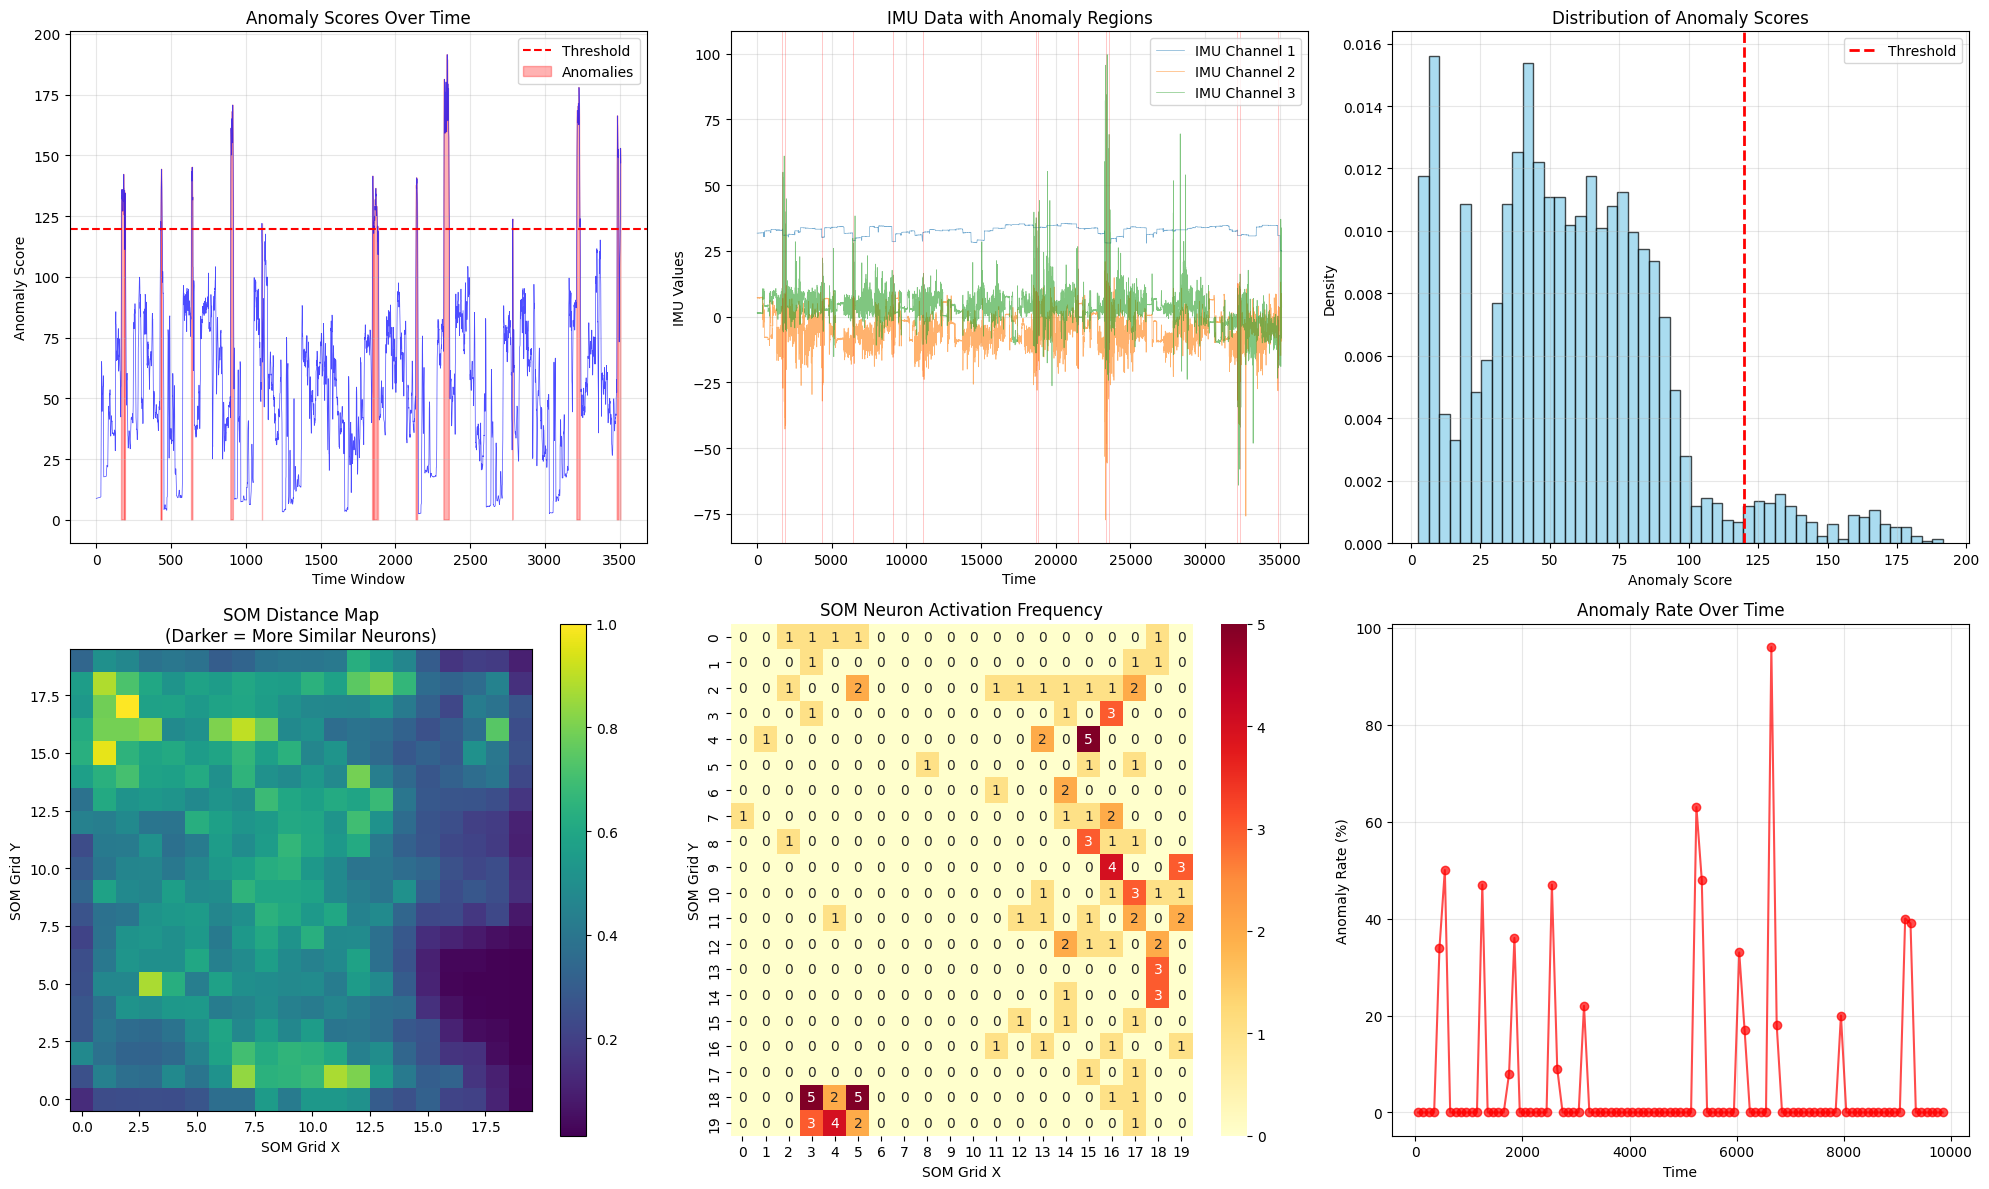

In [ ]:
# Create comprehensive visualization
print("\nGenerating visualizations...")
detector.plot_comprehensive_analysis(
    test_imu_data, anomaly_scores, anomalies, original_anomalies, sample_size=10000
)

In [13]:
def plot_pamap2_specific_analysis(
    data: FloatArray, labels: IntArray, anomalies: BoolArray, column_names: list[str]
) -> None:
    """
    Create PAMAP2-specific analysis plots.

    Args:
        data: IMU sensor data
        labels: Activity labels
        anomalies: Boolean array indicating anomalous time points
        column_names: Names of IMU sensor columns
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Anomaly rate by activity
    ax = axes[0, 0]
    unique_activities = unique(labels)
    activity_anomaly_rates = []
    activity_names = []

    for activity in unique_activities:
        activity_mask = labels == activity
        activity_anomalies = anomalies[activity_mask]
        anomaly_rate = (
            mean(activity_anomalies) * 100 if len(activity_anomalies) > 0 else 0
        )
        activity_anomaly_rates.append(anomaly_rate)
        activity_names.append(get_activity_name(activity))

    bars = ax.bar(
        range(len(unique_activities)),
        activity_anomaly_rates,
        color="skyblue",
        edgecolor="navy",
        alpha=0.7,
    )
    ax.set_xlabel("Activity")
    ax.set_ylabel("Anomaly Rate (%)")
    ax.set_title("Anomaly Detection Rate by Activity Type")
    ax.set_xticks(range(len(unique_activities)))
    ax.set_xticklabels(
        [f"{aid}\n{name[:8]}" for aid, name in zip(unique_activities, activity_names)],
        rotation=45,
        ha="right",
    )
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, rate in zip(bars, activity_anomaly_rates):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{rate:.1f}%",
            ha="center",
            va="bottom",
            fontsize=8,
        )

    # 2. Sensor data by body part during anomalies
    ax = axes[0, 1]
    hand_cols = [i for i, col in enumerate(column_names) if "hand" in col]
    chest_cols = [i for i, col in enumerate(column_names) if "chest" in col]
    ankle_cols = [i for i, col in enumerate(column_names) if "ankle" in col]

    # Sample some data for visualization
    sample_indices = random.choice(len(data), min(1000, len(data)), replace=False)
    sample_data = data[sample_indices]
    sample_anomalies = anomalies[sample_indices]

    # Calculate variance for each body part
    hand_var_normal = (
        var(sample_data[~sample_anomalies][:, hand_cols])
        if any(~sample_anomalies)
        else 0
    )
    hand_var_anomaly = (
        var(sample_data[sample_anomalies][:, hand_cols]) if any(sample_anomalies) else 0
    )
    chest_var_normal = (
        var(sample_data[~sample_anomalies][:, chest_cols])
        if any(~sample_anomalies)
        else 0
    )
    chest_var_anomaly = (
        var(sample_data[sample_anomalies][:, chest_cols])
        if any(sample_anomalies)
        else 0
    )
    ankle_var_normal = (
        var(sample_data[~sample_anomalies][:, ankle_cols])
        if any(~sample_anomalies)
        else 0
    )
    ankle_var_anomaly = (
        var(sample_data[sample_anomalies][:, ankle_cols])
        if any(sample_anomalies)
        else 0
    )

    body_parts = ["Hand", "Chest", "Ankle"]
    normal_vars = [hand_var_normal, chest_var_normal, ankle_var_normal]
    anomaly_vars = [hand_var_anomaly, chest_var_anomaly, ankle_var_anomaly]

    x = arange(len(body_parts))
    width = 0.35

    ax.bar(x - width / 2, normal_vars, width, label="Normal", alpha=0.7, color="green")
    ax.bar(
        x + width / 2, anomaly_vars, width, label="Anomalous", alpha=0.7, color="red"
    )

    ax.set_xlabel("Body Part")
    ax.set_ylabel("Signal Variance")
    ax.set_title("Signal Variance: Normal vs Anomalous Periods")
    ax.set_xticks(x)
    ax.set_xticklabels(body_parts)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Timeline view with activities and anomalies
    ax = axes[1, 0]
    sample_size = min(5000, len(data))
    sample_indices = linspace(0, len(data) - 1, sample_size, dtype=int)

    # Plot activity timeline
    ax.scatter(
        sample_indices,
        labels[sample_indices],
        c="blue",
        alpha=0.6,
        s=1,
        label="Activities",
    )

    # Overlay anomalies
    anomaly_indices = sample_indices[anomalies[sample_indices]]
    if len(anomaly_indices) > 0:
        ax.scatter(
            anomaly_indices,
            labels[anomaly_indices],
            c="red",
            s=10,
            alpha=0.8,
            label="Anomalies",
            marker="x",
        )

    ax.set_xlabel("Time")
    ax.set_ylabel("Activity ID")
    ax.set_title("Activity Timeline with Detected Anomalies")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Correlation heatmap of anomalous vs normal periods
    ax = axes[1, 1]
    if any(anomalies) and any(~anomalies):
        # Sample data for correlation analysis
        normal_sample = sample_data[~sample_anomalies]
        anomaly_sample = sample_data[sample_anomalies]

        if len(normal_sample) > 0 and len(anomaly_sample) > 0:
            # Calculate correlation difference
            normal_corr = corrcoef(normal_sample[: min(500, len(normal_sample))].T)
            anomaly_corr = corrcoef(anomaly_sample[: min(500, len(anomaly_sample))].T)

            # Show difference in correlation patterns
            corr_diff = anomaly_corr - normal_corr

            im = ax.imshow(corr_diff, cmap="RdBu", vmin=-1, vmax=1)
            ax.set_title("Correlation Difference\n(Anomalous - Normal)")
            ax.set_xlabel("Sensor Index")
            ax.set_ylabel("Sensor Index")
            plt.colorbar(im, ax=ax)
        else:
            ax.text(
                0.5,
                0.5,
                "Insufficient data\nfor correlation analysis",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
    else:
        ax.text(
            0.5,
            0.5,
            "No anomalies detected\nfor comparison",
            ha="center",
            va="center",
            transform=ax.transAxes,
        )

    plt.tight_layout()
    plt.show()

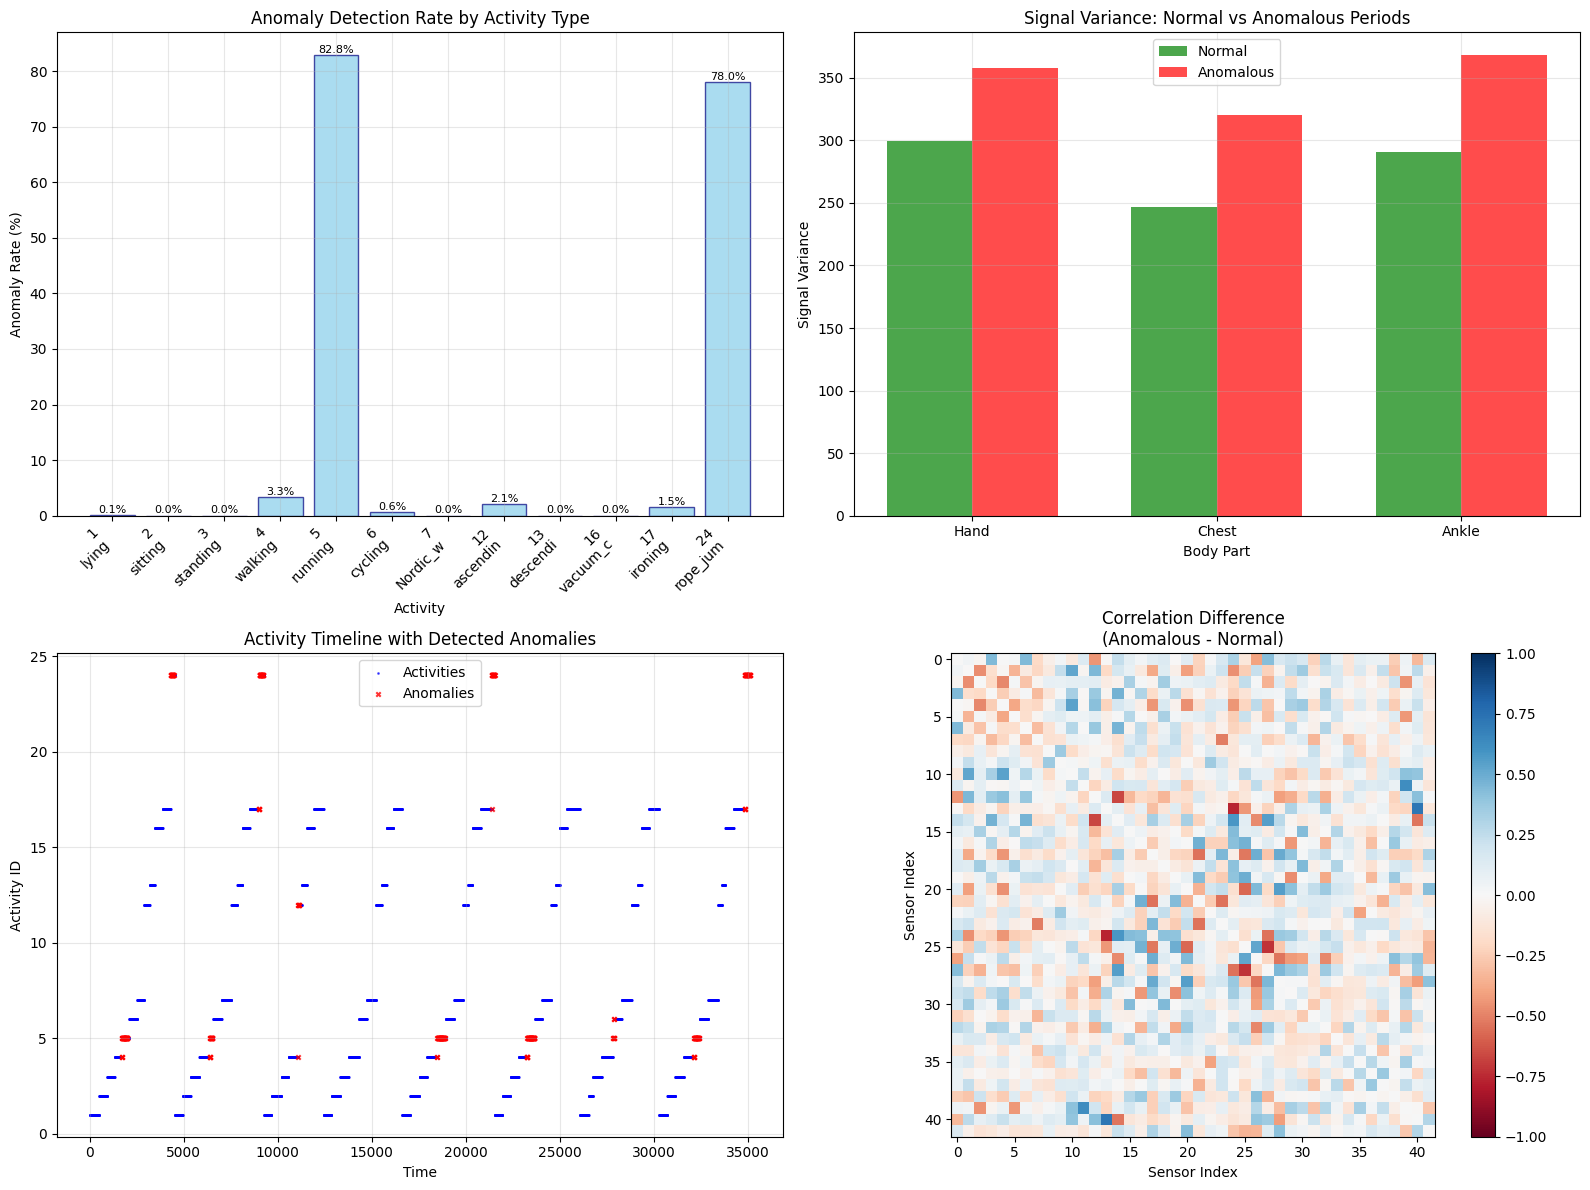

In [15]:
plot_pamap2_specific_analysis(
    test_imu_data, test_labels, original_anomalies, all_imu_columns
)